# Alex's Analysis

I'm going to put all my imports at the top because I'm not some kind of psychopath

In [107]:
import datetime
import json
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import numpy
from functools import reduce
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import statsmodels.tsa.stattools as ts

In [108]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Setup and Cleaning

Read in the data and note that the index is set to the time column

In [109]:
files = os.listdir("data/")
symbols = [f[:-4] for f in files if f[-4:]==".csv"]
print(symbols)
dfs = {f[:-4]: pd.read_csv("data/" + f, index_col="time") for f in files if f[-4:]==".csv"}

['ZECETH', 'TRXETH', 'XRPETH', 'BNBBTC', 'EOSETH', 'LTCBNB', 'DASHBNB', 'XMRBNB', 'DASHUSDT', 'TRXBNB', 'ZECBNB', 'ADABTC', 'ZECUSDT', 'EOSBNB', 'LTCETH', 'XRPBNB', 'XMRETH', 'BNBUSDT', 'DASHETH', 'LTCUSDT', 'ETHBTC', 'TRXUSDT', 'TRXXRP', 'TRXBTC', 'ZECBTC', 'ADABNB', 'ETHUSDT', 'BTCUSDT', 'XMRUSDT', 'EOSBTC', 'BNBETH', 'XRPBTC', 'DASHBTC', 'EOSUSDT', 'XMRBTC', 'ADAETH', 'ADAUSDT', 'XRPUSDT', 'LTCBTC']


I only want the data that has a godawful number of observations

In [110]:
n = 30000
good_dfs = {}
for k, v in dfs.items():
    if v.shape[0] > n:
        good_dfs[k] = v

In [111]:
for k, v in good_dfs.items():
    good_dfs[k].index = pd.to_datetime(good_dfs[k].index, unit="ms", utc=True)

closes_ls = [good_dfs[k]['close'] for k, v in good_dfs.items()]
closes_df = pd.concat(closes_ls, axis=1).dropna()
closes_df.columns = list(good_dfs.keys())
closes_df.shape

(32687, 31)

#### Here's the "fun" part

Notice the dimensions on the close data in the previous cell. That's assuming a uniform index of timestamps from Binance, which is not actually realistic - sometimes the website goes down or is closed for maintenance. We need to check and fill missing data (using fill forward, assumption that prices haven't changed). Notice that the largest period was 615 minutes down, 10ish hours.

In [112]:
bad_times = list(pd.DataFrame(closes_df.index).time.diff().unique())
[i.astype('timedelta64[m]') for i in bad_times] 

[numpy.timedelta64('NaT','m'),
 numpy.timedelta64(15,'m'),
 numpy.timedelta64(615,'m'),
 numpy.timedelta64(120,'m'),
 numpy.timedelta64(465,'m'),
 numpy.timedelta64(225,'m'),
 numpy.timedelta64(435,'m'),
 numpy.timedelta64(375,'m')]

In [113]:
closes_df = closes_df.resample('15T').max()
closes_df.fillna(method="ffill", inplace=True)
closes_df.shape # The dimensions have changed!

(32870, 31)

In [114]:
dfs_keys = good_dfs.keys()
usd_pairs = list(filter(lambda x:  x[-4:] == 'USDT', list(dfs_keys)))
btc_pairs = list(filter(lambda x:  x[-3:] == 'BTC', list(dfs_keys)))
eth_pairs = list(filter(lambda x:  x[-3:] == 'ETH', list(dfs_keys)))
bnb_pairs = list(filter(lambda x:  x[-3:] == 'BNB', list(dfs_keys)))
pairs = {'USD': usd_pairs, 'BTC': btc_pairs, 'ETH': eth_pairs, 'BNB': bnb_pairs}

In [115]:
close_prices = closes_df[pairs['USD']]
# close_prices = closes_df

#### Simple manipulations

We definitely want the log prices for pairs trading, but we also probably want the returns data. 

In [116]:
log_prices = FunctionTransformer(func=numpy.log).fit_transform(close_prices)
returns = pd.DataFrame(log_prices).diff()
returns.columns = close_prices.columns
returns = returns.drop(returns.index[0])
returns.corr()

,BNBUSDT,LTCUSDT,TRXUSDT,ETHUSDT,BTCUSDT,EOSUSDT,ADAUSDT,XRPUSDT
BNBUSDT,1.000000,0.496561,0.490588,0.554598,0.551974,0.507958,0.514062,0.444468
LTCUSDT,0.496561,1.000000,0.606620,0.765425,0.739385,0.724486,0.668983,0.586141
TRXUSDT,0.490588,0.606620,1.000000,0.675607,0.675920,0.632102,0.671486,0.581334
ETHUSDT,0.554598,0.765425,0.675607,1.000000,0.792550,0.763085,0.736680,0.653302
BTCUSDT,0.551974,0.739385,0.675920,0.792550,1.000000,0.738121,0.732192,0.634479
EOSUSDT,0.507958,0.724486,0.632102,0.763085,0.738121,1.000000,0.687285,0.609630
ADAUSDT,0.514062,0.668983,0.671486,0.736680,0.732192,0.687285,1.000000,0.635516
XRPUSDT,0.444468,0.586141,0.581334,0.653302,0.634479,0.609630,0.635516,1.000000


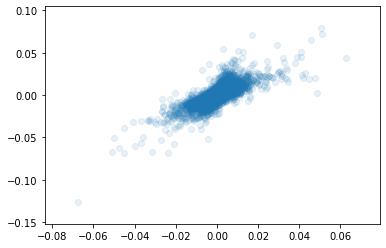

In [117]:
plt.scatter(returns['BTCUSDT'], returns['ETHUSDT'], alpha=0.1)

## Dimensionality Analysis

Here is some simple dimensionality reduction analysis of the returns. This isn't directly related to the project goal, but it does reveal some interesting patterns in the returns data and utilizes sklearn on the dataset.

In [ ]:
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('tsne', TSNE(n_components=2, random_state=42))
])

x_t = pipeline.fit_transform(returns)

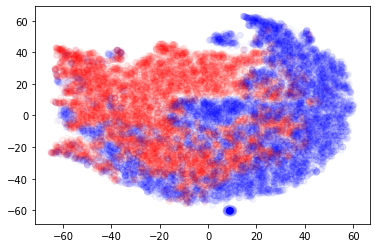

In [1470]:
plt.scatter(x_t[:, 0], x_t[:, 1], alpha=0.02, c=np.where(returns.iloc[:,0] > 0, "red", "blue"))

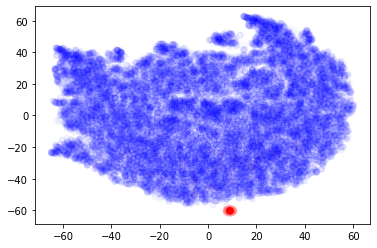

In [1471]:
plt.scatter(x_t[:, 0], x_t[:, 1], alpha=0.02, c=np.where(returns.iloc[:,0] == 0, "red", "blue"))

## Cointegration

This is where we get into actual pairs trading potential. I first outline a single pair of assets and the estimation of their cointegration. I then do the multivariate case - where many asset cointegrations are assessed. This allows for the intended machine learning model.


### Single Asset Pair

The plot below looks for cointegration between Bitcoin and Ethereum. This uses a library to do the calculation, but it's apparent that there is considerable variation in the p-value for cointegration existence. Where the solid line dips below the dashed ones, there is evidence of statistically significant cointegration.

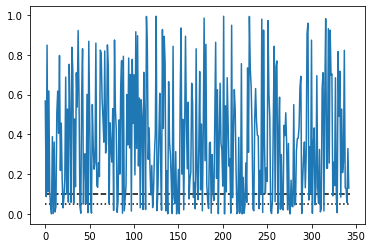

In [118]:
labels = close_prices.index.strftime('%Y-%m-%d')
unique_labels = labels.unique()

cointegration = []
for i in range(len(unique_labels)):
    asset1 = log_prices[np.where(labels == unique_labels[i]), 3]
    asset2 = log_prices[np.where(labels == unique_labels[i]), 4]
    result = ts.coint(asset1[0], asset2[0])
    cointegration.append(result[1])

plt.plot(cointegration)
plt.hlines(0.1, xmin=0, xmax=len(cointegration), linestyles='dashed')
plt.hlines(0.05, xmin=0, xmax=len(cointegration), linestyles='dotted')

In [119]:
valid = unique_labels[np.where(pd.Series(cointegration) < 0.05)][5]
idx = np.where(labels == valid)[0]
start = idx[0]
stop  = idx[len(idx)-1]

This is the cointegration estimate using the stattools library. The first value is the t-stat of the test, the second is the p-value, and the array in the third spot is the list of values at the 1%, 5%, and 10% level of rejection for cointegration. Google "stattools cointegration python" for documentation details.

In [120]:
result=ts.coint(log_prices[start:stop, 3], log_prices[start:stop, 4])
result

(-3.4778488118424917,
 0.03441021390174744,
 array([-4.01674394, -3.40190325, -3.08987698]))

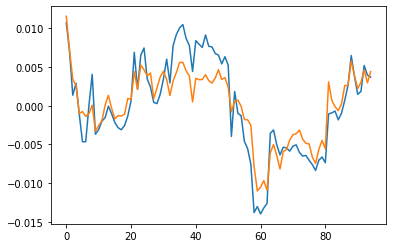

In [121]:
eth = log_prices[start:stop, 3] - np.mean(log_prices[start:stop, 3])
btc = log_prices[start:stop, 4] - np.mean(log_prices[start:stop, 4])

plt.plot(np.exp(eth) - 1)
plt.plot(np.exp(btc) - 1)

This is a direct linear regression on these two non-stationary time series (Bitcoin price against Ethereum price). The idea is to do this linear regression on a rolling period and the level at which the residuals are mean reverting is what we want to predict.

In [122]:
from sklearn.linear_model import LinearRegression

subset = pd.DataFrame(log_prices[start:stop, :])
y = subset[3].values
x = subset[4].values.reshape(-1, 1)
linreg = LinearRegression().fit(x, y)
linreg.coef_[0]

1.2580604969917735

Here are the mean reverting residuals

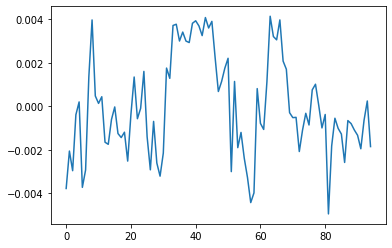

In [123]:
plt.plot(y - linreg.predict(x))

#### Single Asset, Rolling Window

Rather than having discrete intervals with no overlap, we would prefer to use all our data. That means that we need to calculate a rolling interval of p-tests. For prediction, this is a bit tricky, as we need to predict not *the next* observation, but *the n'th next* observation where n is the period used for rolling. Below, I simply plot a rolling average for the price to demonstrate the python pandas rolling functionality, then I manually calculate the rolling p-stat using the function I defined, `get_cointegration`. Note the time spent calculating the p-stats!

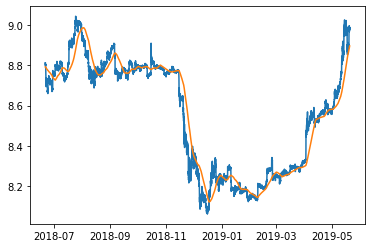

In [124]:
m = 1000

log_df = pd.DataFrame(log_prices)
log_df.index = close_prices.index
roll_mean = log_df.rolling(m).mean()
joined = pd.concat([log_df, roll_mean], axis=1).dropna()
joined.columns = ['price_' + i for i in usd_pairs] + ['avg_' + i for i in usd_pairs]
plt.plot(joined['price_BTCUSDT'])
plt.plot(joined['avg_BTCUSDT'])

In [125]:
n = log_df.shape[0]
m = 100

log_df = pd.DataFrame(log_prices)
log_df.index = close_prices.index
log_df.columns = usd_pairs

def get_cointegration(asset_1, asset_2):
    cointegrations = []

    for i in range(0, (n-m)):
        roll_df = log_df.iloc[i:(i+m), :]
        btc = roll_df[asset_1]
        eth = roll_df[asset_2]
        cointegrations.append(ts.coint(btc, eth)[1])
    
    return cointegrations

cointegrations = get_cointegration('BTCUSDT', 'ETHUSDT')

In [213]:
import datetime
import json
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import numpy
from functools import reduce
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import statsmodels.tsa.stattools as ts

import warnings

class RollingAnalyzer:
    
    def __init__(self, prices, m):
        self.prices = prices
        self.returns = pd.DataFrame(prices).diff()
        self.n = prices.shape[0]
        self.m = m
        self.rolled_dfs = None
        self.regressions = {}
        self.pairs = []
    
    def make_dfs(self):
        roll_range = range(0, self.n - self.m)
        self.rolled_dfs = [pd.DataFrame(self.prices.iloc[i:(i+self.m), :]) for i in roll_range]
    
    def run_regressions(self, asset_1, asset_2):
        code = asset_1 + '_' + asset_2
        self.regressions[code] = []
        for df in self.rolled_dfs:
            date_range = df.index[0], df.index[df.shape[0]-1]
            x = df[asset_1].values.reshape(-1, 1)
            y = df[asset_2].values
            linear_regression = LinearRegression().fit(x, y)
            residuals = y - linear_regression.predict(x)
            reg_dict = {
                'date_range': date_range,
                'regression': linear_regression,
                'residuals': residuals,
            }
            self.regressions[code].append(reg_dict)
        
    def asset_loop(self):
        for i in range(0, self.prices.shape[1]):
            pair_i = self.prices.columns[i]
            for j in range(0, i):
                pair_j = self.prices.columns[j]
                if pair_i != pair_j:
                    self.pairs.append((pair_i, pair_j))
    
    def run_all_regressions(self):
        if not self.pairs:
            print("Must make pairs")
        else:
            for pair in self.pairs:
                self.run_regressions(pair_i, pair_j)
    
    def calc_dickey_fuller(self, asset_1, asset_2):
        code = asset_1 + '_' + asset_2
        if code not in self.regressions.keys():
            print('Assets not regressed yet')
        else:
            for regression in self.regressions[code]:
                regression['dickey_fuller'] = ts.adfuller(regression['residuals'])
                
    def calc_all_dickey_fullers(self):
        if not self.pairs:
            print("Must make pairs")
        else:
            for pair in self.pairs:
                self.calc_dickey_fuller(pair_i, pair_j)        
                
    def export_df(self):
        dickey_fullers = {}
        date_index = []
        for k, v in self.regressions.items():
            dickey_fullers[k] = v['dickey_fuller']
            date_index.append(v['date_range'][0])
        out_df = pd.from_dict(dickey_fuller)
        out_df.index = date_index
        return(out_df)


In [214]:
%time rolling_analyzer = RollingAnalyzer(log_df, 100)

CPU times: user 1.98 s, sys: 294 ms, total: 2.28 s
Wall time: 2.27 s


In [217]:
%time rolling_analyzer.make_dfs()

CPU times: user 6.75 s, sys: 37.2 ms, total: 6.79 s
Wall time: 6.77 s


In [218]:
%time rolling_analyzer.asset_loop()

CPU times: user 97 µs, sys: 25 µs, total: 122 µs
Wall time: 137 µs


In [219]:
%time rolling_analyzer.run_all_regressions()

CPU times: user 5min 28s, sys: 1.97 s, total: 5min 30s
Wall time: 5min 29s


In [212]:
%time rolling_analyzer.calc_dickey_fuller("BTCUSDT", "ETHUSDT")

CPU times: user 2min 24s, sys: 448 ms, total: 2min 24s
Wall time: 2min 24s


TypeError: string indices must be integers

32770

Now that we have our rolling p-stat calculations, we can plot them. Feel free to plot the whole series, but I have subsetted a single week below for demonstration purposes.

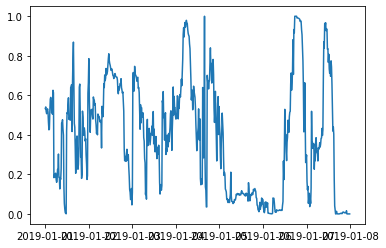

In [1493]:
coint_series = pd.Series(cointegrations)
coint_series.index = log_df.index[m:]
plt.plot(coint_series['2019-01-01':'2019-01-07'])

Again, I have hand picked a period of cointegration for plotting. However, notice this time that you can move the window (`good_time`) by 1 and it likely "sticks with" the period because of the rolling that has been applied.

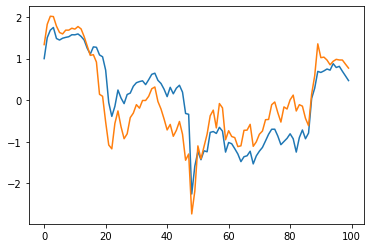

In [1534]:
good_times = np.where(coint_series < 0.1)[0]
good_time = 16

t1 = coint_series.index[good_times[good_time]]
t2 = t1 + m - 1
timeframe = close_prices[t1:t2]
plt.plot(scale(timeframe['BTCUSDT']))
plt.plot(scale(timeframe['ETHUSDT']))

Is there any correlation between the cointegration today and the cointegration n periods from now? Here is a plot with the lag in question.

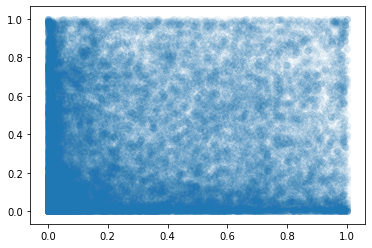

In [1498]:
lag_correction = pd.concat([coint_series, coint_series.shift(-m)], axis=1).dropna()
plt.scatter(lag_correction[0], lag_correction[1], alpha=0.05)

This isn't particularly helpful, so I do the transform on the range from 0 to 1 to infitntiy to infinity

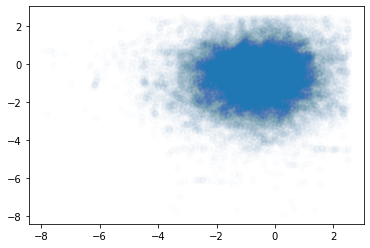

In [1536]:
import scipy.stats as st

#inf_range = st.norm.ppf(lag_correction)
plt.scatter(
    st.norm.ppf(lag_correction[0], loc=0, scale=1),
    st.norm.ppf(lag_correction[1], loc=0, scale=1),
    alpha=0.01)

It looks like there is no correlation! Shit! This is basically the idea of the project, to get a model that predicts the next period's cointegration level. Ideally, we use not only data from the original time series of p-values, but also the time series of p-values *of other asset pairs* to construct this model.

#### New heading

### Multivariate Cointegration Pairs

While the previous section was purely Bitcoin and Ethereum, this section looks into other pairsing (Bitcoin and Litecoin, Ethereum and Litecoin, Bitcoin and Binance Coin, etc). I check the correlation on the cointegration, and it does seem that some assets exhibit cointegration simultaneously.

Here is the code to get the calculations. **Note the time! This takes a long time to calculate!**

In [1134]:
%%time

cointegration_mv = {}
for i in range(0, len(usd_pairs)):
    pair_i = usd_pairs[i]
    print(pair_i)
    for j in range(0, i):
        pair_j = usd_pairs[j]
        print(pair_j)
        if pair_i != pair_j:
            code = pair_i + '_' + pair_j
            print(code)
            cointegration_mv[code] = get_cointegration(pair_i, pair_j)

BNBUSDT
LTCUSDT
BNBUSDT
LTCUSDT_BNBUSDT
TRXUSDT
BNBUSDT
TRXUSDT_BNBUSDT
LTCUSDT
TRXUSDT_LTCUSDT
ETHUSDT
BNBUSDT
ETHUSDT_BNBUSDT
LTCUSDT
ETHUSDT_LTCUSDT
TRXUSDT
ETHUSDT_TRXUSDT
BTCUSDT
BNBUSDT
BTCUSDT_BNBUSDT
LTCUSDT
BTCUSDT_LTCUSDT
TRXUSDT
BTCUSDT_TRXUSDT
ETHUSDT
BTCUSDT_ETHUSDT
EOSUSDT
BNBUSDT
EOSUSDT_BNBUSDT
LTCUSDT
EOSUSDT_LTCUSDT
TRXUSDT
EOSUSDT_TRXUSDT
ETHUSDT
EOSUSDT_ETHUSDT
BTCUSDT
EOSUSDT_BTCUSDT
ADAUSDT
BNBUSDT
ADAUSDT_BNBUSDT
LTCUSDT
ADAUSDT_LTCUSDT
TRXUSDT
ADAUSDT_TRXUSDT
ETHUSDT
ADAUSDT_ETHUSDT
BTCUSDT
ADAUSDT_BTCUSDT
EOSUSDT
ADAUSDT_EOSUSDT
XRPUSDT
BNBUSDT
XRPUSDT_BNBUSDT
LTCUSDT
XRPUSDT_LTCUSDT
TRXUSDT
XRPUSDT_TRXUSDT
ETHUSDT
XRPUSDT_ETHUSDT
BTCUSDT
XRPUSDT_BTCUSDT
EOSUSDT
XRPUSDT_EOSUSDT
ADAUSDT
XRPUSDT_ADAUSDT
CPU times: user 1h 42min 14s, sys: 11.3 s, total: 1h 42min 25s
Wall time: 1h 42min 29s


In [1568]:
from scipy.stats import norm

coint_df = pd.DataFrame.from_dict(cointegration_mv)
coint_df.index = log_df.index[m:]

def to_good_range(col):
    return norm.ppf(col, loc=0, scale=1)

coint_inf_df = coint_df.apply(to_good_range)

In [1636]:
from sklearn.svm import SVR

subset = coint_df.iloc[0:2000, :]

target_label = 'BTCUSDT_ETHUSDT'
target = subset[target_label].shift(-m)[:-m]
features = subset.drop(columns=target_label)[:-m]
lag = features.shift(1)
lag.columns = [c + '_lag' for c in lag.columns]

df = pd.concat([target, features, lag], axis=1).dropna()
target_label2 = target_label + '_future'
df = df.rename(columns={target_label: target_label2})

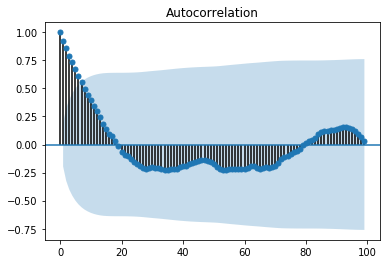

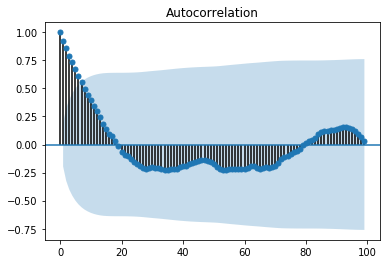

In [1659]:
plot_acf(df[target_label2][0:100])

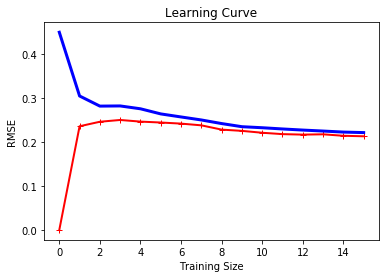

In [1637]:
def split_train_test(data, test_ratio):
    n = data.shape[0]
    test_set_size = int(n * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

def plot_learning_curves(model, data, ylab):
    train, test = split_train_test(data, 0.2)
    y_train = train[ylab].copy()
    y_test = test[ylab].copy()

    train = train.drop(ylab, axis=1)
    test = test.drop(ylab, axis=1)

    train_errors, test_errors = [], []
    for m in range(1, len(train), 100):
        model.fit(train[:m], y_train[:m])
        y_train_predict = model.predict(train[:m])
        y_test_predict = model.predict(test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label="train")
    plt.plot(np.sqrt(test_errors), 'b-', linewidth=3, label='test')
    plt.xlabel('Training Size')
    plt.ylabel('RMSE')
    plt.title('Learning Curve')
    
plot_learning_curves(SVR(), df, target_label2)

In [1643]:
from sklearn.metrics import mean_squared_error

y = df[target_label2]
x = df.drop([target_label2], axis=1)
model = SVR().fit(x, y)
predictions = model.predict(x)
np.sqrt(mean_squared_error(y, predictions))

0.20767378567203446

In [32]:
x

NameError: name 'x' is not defined

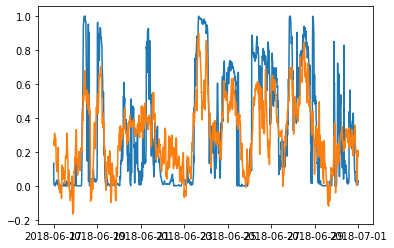

In [1652]:
plt.plot(df[target_label2]['2018-06-17':'2018-06-30'])
pred_df = pd.DataFrame(predictions)
pred_df.index = df.index
plt.plot(pred_df['2018-06-17':'2018-06-30'])

(0, 200)

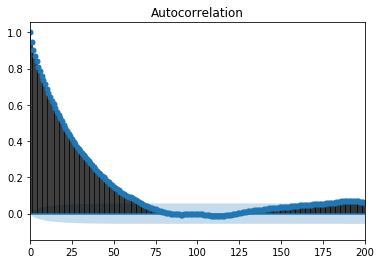

In [1349]:
coint_inf_df[np.isfinite(coint_inf_df) != True] = 0
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(pd.Series(coint_inf_df.iloc[:, 4]))
plt.xlim(0,200)

(-5, 5)

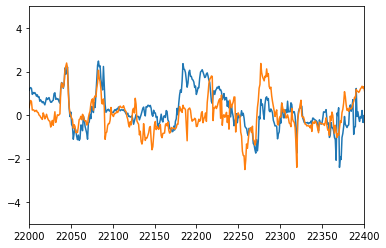

In [1350]:
plt.plot(coint_inf_df["EOSUSDT_BNBUSDT"])
plt.plot(coint_inf_df["LTCUSDT_BNBUSDT"])
plt.xlim(22000,22400)
plt.ylim(-5,5)